In [1]:
import numpy as np
import pandas as pd

In [52]:
SEED = 0
NUM_ANTS = int(1e5)
MAX_STEPS = 100

In [3]:
np.random.seed(SEED)

In [4]:
# def create_ants(num_ants):

#     ants = pd.DataFrame(columns = ['x', 'y', 'food'])
#     ants['x'] = np.zeros(num_ants)
#     ants['y'] = np.zeros(num_ants)
#     ants['food'] = np.full((num_ants, 1), False, dtype=bool)

#     return ants

In [42]:
def constraints(x, y):
    if -2<x<2 and -2<y<2:
        return True
    return False

class Ants():
    def __init__(self, n:int) -> None:
        if n<=0:
            raise ValueError("Error: 'n' must be a positive integer")
        self.num_initial = n
        self.num_alive = n
        self.perc_alive = 1.0
        self.step = 0
        self.death_history = {0: 0}
        self.positions = self.initial_positions()
        self.possible_moves =  np.array([[1,0], [-1,0], [0,1], [0,-1]])

    def initial_positions(self):
        
        positions = pd.DataFrame(columns = ['x', 'y'])
        positions['x'] = np.zeros(self.num_initial)
        positions['y'] = np.zeros(self.num_initial)
        
        return positions

    def move(self):
        self.step +=1
        moves = self.possible_moves[np.random.choice(4, self.num_alive)]
        self.positions += moves
        alive = self.positions.apply(lambda pos: constraints(pos['x'], pos['y']), axis=1)
        self.death_history[self.step] = (~alive).astype(int).sum()
        self.num_alive -= self.death_history[self.step]
        self.perc_alive = self.num_alive/self.num_initial
        self.positions = self.positions[alive]
        return self.death_history[self.step]

In [50]:
def tracking(ants, max_steps=1):
    
    print(f'step:\tdeath\talive\tperc_alive')

    while ants.step<=max_steps and ants.num_alive>0:
        ants.move()
        if ants.step%5==0 or ants.step>max_steps or ants.num_alive<=0:
            print(f'{ants.step}:\t{ants.death_history[ants.step]}\t{ants.num_alive}\t{ants.perc_alive}')

    death_history = pd.DataFrame.from_dict(ants.death_history, orient='index', columns=['num'])
    death_history.index.name = 'step'
    death_history.sort_index(inplace=True)


    return death_history

In [54]:
print('Ants creation...')
ants = Ants(NUM_ANTS)
print('Movements tracking...')
death_history = tracking(ants, MAX_STEPS)

Ants creation...
Movements tracking...
step:	death	alive	perc_alive
5:	12450	25064	0.25064
10:	1531	4773	0.04773
15:	400	795	0.00795
20:	53	133	0.00133
25:	5	21	0.00021
30:	2	4	4e-05
33:	1	0	0.0


<AxesSubplot:xlabel='step'>

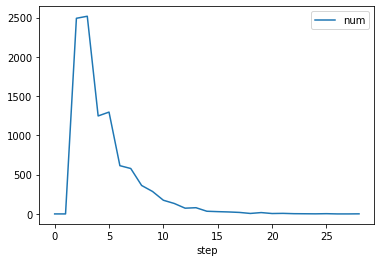

In [48]:
death_history.plot()